## U-Net для сегментации изображений.

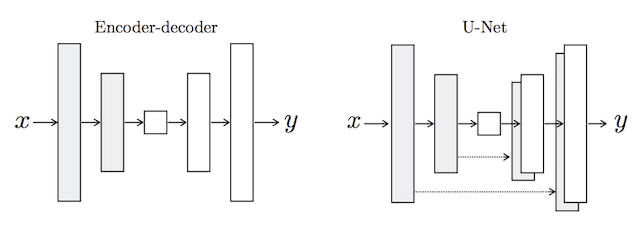

Сделаем похожий на U-Net GAN из MobileNetV2 и Pix2pix.
* MobileNetV2 осуществляет свёртку исходного изображения в карту признаков.
* Pix2pix осуществляет "развёртку" масок сегментации из карты признаков.

Будем использовать предобученные модели из `tensorflow.keras.applications`.

По смыслу не совсем GAN: нет состязательности генератора и дискриминатора, а скорее кооперация энкодера и декодера (анализа и синтеза). Также есть bypass каналы.

Альтернатива архитектурам со скользящим окном.

Достаточно эффективна на небольших датасетах.

## Freiburg U-Net

Университет Фрайбурга предложил архитектуру для сегментации медицинских изображений.

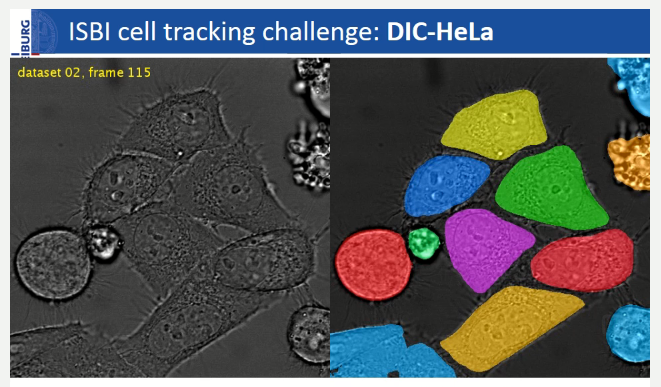

В медицинских датасетах часто очень мало изображений, потому что их сложно получать (рентгеновские снимки, снимки компьютерной томографии, снимки с электронных микроскопов и т.п.).

Решили задачу сегментации изображений при небольшом размере датасета.

Предложена U-Net архитектура: кооперация свёртки изображения в карту признаков и "развёртки" карты признаков в маски сегментации объектов. Также есть bypass каналы.

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

MobileNetV2 - на основе Inception блоков: параллельные свёртки с разным размером окна.

Pix2pix - хорошо преобразует одно изображение в другое. В нашем случае на входе - не изображение, а карта признаков. Преобразуется в сегменты объектов.

In [ ]:
# Устанавливаем примеры TensorFlow прямо из git репозитория с GitHub.
!pip install -q git+https://github.com/tensorflow/examples.git

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix

ModuleNotFoundError: ignored

In [ ]:
# Скачиваем датасет.
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

In [ ]:
TRAIN_LENGTH = info.splits["train"].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1024
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
# Нормализация и изменения индекса типа маски на нумерацию с нуля.
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
# Загрузка изображения из датасета, с изменением размера и нормализацией.

# Декоратор, который производит трассирующую трансляцию функции в tensorflow.Graph.
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  print(type(datapoint['segmentation_mask']))
  print(datapoint['segmentation_mask'])

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

@tf.function
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
train = dataset["train"].map(load_image_train)
test = dataset["test"].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
import matplotlib.pyplot as plt

# Отображение изображения.
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Изображение", "Истинная маска", "Вычисленная маска"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

In [ ]:
for image, mask in test.take(15):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:
OUTPUT_CHANNELS = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [ ]:
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [ ]:
up_stack = [
    pix2pix.upsample(filters=512, size=3),  # 4x4 -> 8x8
    pix2pix.upsample(filters=256, size=3),  # 8x8 -> 16x16
    pix2pix.upsample(filters=128, size=3),  # 16x16 -> 32x32
    pix2pix.upsample(filters=64,  size=3),  # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Down sampling
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and skips.
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding="same"
  )

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Наносит маску на изображение.
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

# Отображает группу: изображение, истинная маска, вычисленная маска.
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions()

In [ ]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print(f"\nПример после эпохи {epoch+1}\n")

In [ ]:
MODEL_PATH = "drive/MyDrive/6_advanced_architectures"

In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits["test"].num_examples//BATCH_SIZE//VAL_SUBSPLITS

epoch_checkpoint = tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/6_advanced_architectures/epoch_{epoch}.h5")

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), epoch_checkpoint])

model.save(MODEL_PATH)

In [ ]:
loss = model_history.history["loss"]
val_loss = model_history.history["val_loss"]

plt.figure()
plt.plot(model_history.epoch, loss, "r", label="Обучение")
plt.plot(model_history.epoch, val_loss, "b", label="Валидация")
plt.title("Loss при обучении и валидации")
plt.xlabel("Эпоха")
plt.xticks(range(0, EPOCHS-1))
plt.ylabel("Значение loss")
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
print(model_history.history)

In [ ]:
model.load_weights(f"{MODEL_PATH}/epoch_5.h5")

In [ ]:
show_predictions(test_dataset, 10)